In [2]:
#     API Quandl
#     Data cleanup
#     Materials = XLB
#     Real Estate = RWR
#     Technology = XLK
#     S&P500 = SPY

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [4]:
#QUANDL Data retrieval

#Load quandl api_key
load_dotenv()

api_key = os.getenv("QUANDL_API_KEY")
type(api_key)



str

In [5]:
#Create request url to access quandl to get prices for XLB, S&P Materials Sector ETF

#request_url = "https://www.quandl.com/api/v3/datasets/WIKI/XLB.json?api_key="
request_url = "https://www.quandl.com/api/v3/datasets/WIKI/RWR/data.csv?api_key="

# Concatenate request_url and api_key. Store as new variable
request_url_api = request_url + api_key


In [6]:
# Execute get request, this returned error, XLB, RWR, and XLK not in free wiki dataset.

response_data = requests.get(request_url_api)
response_data.content

b'code,message\nQECx02,You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.\n'

In [7]:
#Try ALPACA data retrieval next
load_dotenv()

APCA_API_KEY_ID = os.getenv("APCA_API_KEY_ID")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')

type(APCA_API_KEY_ID)


str

In [8]:
#Use alpha vantage to get historic quotes for XLB,XLK,RWR. This goes back 20 years.

xlb_df = api.alpha_vantage.historic_quotes('XLB', adjusted=True, output_format='pandas')
#xlb_df.head()

xlk_df = api.alpha_vantage.historic_quotes('XLK', adjusted=True, output_format='pandas')
# xlk_df.tail()

rwr_df = api.alpha_vantage.historic_quotes('RWR', adjusted=True, output_format='pandas')
#rwr_df.head()

#Use alpha vantage to get historic quotes for S&P500. Will need this later.

spy_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')



#CODE BELOW WAS FIRST ATTEMPT BUT ONLY GETS 1000 TRADING DAYS:

# # Get daily price data for XLB over the last 1000 trading days. Max alpaca would allow.
# #download direct into dataframe

# barset = api.get_barset('XLB', 'day', limit=1000).df
# xlb_bars_df = barset['XLB']
# xlb_bars_df.head()
# xlb_bars_df.tail()

# Get daily price data for XLK over the last 1000 trading days. Max alpaca would allow.

# barset = api.get_barset('XLK', 'day', limit=1000).df
# xlk_bars_df = barset['XLK']
# xlk_bars_df.head()
# xlk_bars_df.tail()

# # Get daily price data for RWR over the last 1000 trading days. Max alpaca would allow.

# barset = api.get_barset('RWR', 'day', limit=1000).df
# rwr_bars_df = barset['RWR']
# rwr_bars_df.head()
# rwr_bars_df.tail()





In [9]:
spy_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-30,291.71,293.3239,288.59,290.48,290.48,113667554.0,0.0,1.0
2020-04-29,291.53,294.8800,290.41,293.21,293.21,118066585.0,0.0,1.0
2020-04-28,291.02,291.4000,285.40,285.73,285.73,104797847.0,0.0,1.0
2020-04-27,285.12,288.2700,284.62,287.05,287.05,77516422.0,0.0,1.0
2020-04-24,280.73,283.7000,278.50,282.97,282.97,85042563.0,0.0,1.0


In [10]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xlb_df = xlb_df['5. adjusted close']
xlb_df.head()

xlk_df = xlk_df['5. adjusted close']
xlk_df.head()

rwr_df = rwr_df['5. adjusted close']
rwr_df.head()

spy_df = spy_df['5. adjusted close']
spy_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xlb_df, xlk_df, rwr_df, spy_df], axis = "columns", join = "inner")
concat_df.head()



,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,
2020-04-30,51.88,91.41,77.87,290.48
2020-04-29,53.47,91.82,79.10,293.21
2020-04-28,52.14,88.20,77.38,285.73
2020-04-27,51.19,89.39,76.08,287.05
2020-04-24,49.86,88.63,73.25,282.97


In [11]:
#Change column names to avoid confusion
columns = ['XLB close', 'XLK close', 'RWR close', 'SPY close']
concat_df.columns = columns
concat_df.head()

,XLB close,XLK close,RWR close,SPY close
date,,,,
2020-04-30,51.88,91.41,77.87,290.48
2020-04-29,53.47,91.82,79.10,293.21
2020-04-28,52.14,88.20,77.38,285.73
2020-04-27,51.19,89.39,76.08,287.05
2020-04-24,49.86,88.63,73.25,282.97


In [12]:
#Sort earliest to latest so that .pct_change() function works right

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()


,XLB close,XLK close,RWR close,SPY close
date,,,,
2001-08-27,14.5697,19.3468,19.2651,82.1301
2001-08-28,14.4324,18.8107,19.2651,80.9499
2001-08-29,14.2494,18.4533,18.8996,80.1862
2001-08-30,14.1971,17.7384,18.8082,78.6589
2001-08-31,14.3213,17.8861,18.7625,79.2837


In [13]:
#add another column to get daily returns of XLB
daily_returns_xlb = concat_df["XLB close"].pct_change()
concat_df['XLB_return']= daily_returns_xlb 

#add another column to get daily returns of XLK
daily_returns_xlk = concat_df['XLK close'].pct_change()
concat_df['XLK_return']= daily_returns_xlk 

#add another column to get daily returns of RWR
daily_returns_rwr = concat_df['RWR close'].pct_change()
concat_df['RWR_return']= daily_returns_rwr 

#add another column to get daily returns of SPY
daily_returns_spy = concat_df['SPY close'].pct_change()
concat_df['SPY_return']= daily_returns_spy 


concat_df.head()


,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
date,,,,,,,,
2001-08-27,14.5697,19.3468,19.2651,82.1301,NaN,NaN,NaN,NaN
2001-08-28,14.4324,18.8107,19.2651,80.9499,-0.009424,-0.027710,0.000000,-0.014370
2001-08-29,14.2494,18.4533,18.8996,80.1862,-0.012680,-0.019000,-0.018972,-0.009434
2001-08-30,14.1971,17.7384,18.8082,78.6589,-0.003670,-0.038741,-0.004836,-0.019047
2001-08-31,14.3213,17.8861,18.7625,79.2837,0.008748,0.008327,-0.002430,0.007943


In [14]:
#check for nulls

concat_df.isnull().sum()

XLB close     0
XLK close     0
RWR close     0
SPY close     0
XLB_return    1
XLK_return    1
RWR_return    1
SPY_return    1
dtype: int64

In [15]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLB close     0
XLK close     0
RWR close     0
SPY close     0
XLB_return    0
XLK_return    0
RWR_return    0
SPY_return    0
dtype: int64

In [16]:
# Checking for duplicate rows
concat_df.duplicated()

date
2001-08-28    False
2001-08-29    False
2001-08-30    False
2001-08-31    False
2001-09-04    False
              ...  
2020-04-24    False
2020-04-27    False
2020-04-28    False
2020-04-29    False
2020-04-30    False
Length: 4697, dtype: bool

In [17]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [18]:
#Check datatypes

concat_df.dtypes

XLB close     float64
XLK close     float64
RWR close     float64
SPY close     float64
XLB_return    float64
XLK_return    float64
RWR_return    float64
SPY_return    float64
dtype: object

In [19]:
#check counts
concat_df.count()

XLB close     4697
XLK close     4697
RWR close     4697
SPY close     4697
XLB_return    4697
XLK_return    4697
RWR_return    4697
SPY_return    4697
dtype: int64

In [20]:
#use describe to explore data
concat_df.describe()

,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
count,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000
mean,32.471062,30.813590,53.344132,140.139485,0.000386,0.000439,0.000477,0.000345
std,13.546339,20.089398,23.918002,69.580676,0.015142,0.014745,0.018884,0.012345
min,11.161600,8.997400,15.299700,54.152900,-0.124649,-0.138140,-0.208544,-0.109423
25%,20.762800,16.710100,33.193500,87.506300,-0.006596,-0.005676,-0.005945,-0.004157
50%,30.480800,21.597000,49.625900,110.017100,0.000828,0.000939,0.000838,0.000659
75%,43.478000,39.181400,75.258000,188.087500,0.008200,0.006926,0.007443,0.005637
max,61.111600,102.250500,106.602100,336.274200,0.117601,0.134921,0.174806,0.139609


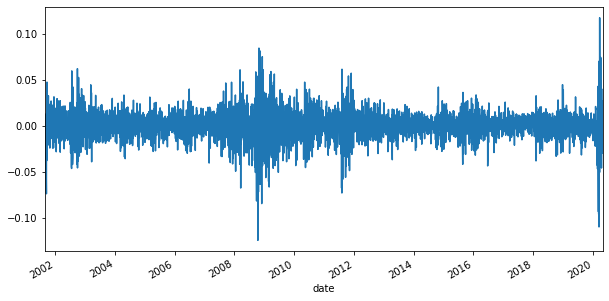

In [21]:
#plot daily returns of XLB

#concat_df['XLB_return'].plot(figsize=(10,5))
daily_returns_xlb.plot(figsize=(10,5))

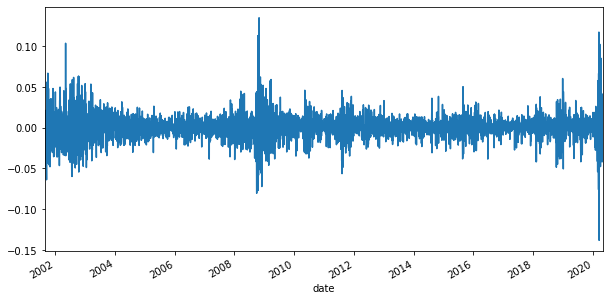

In [22]:
#plot daily returns of XLK

daily_returns_xlk.plot(figsize=(10,5))

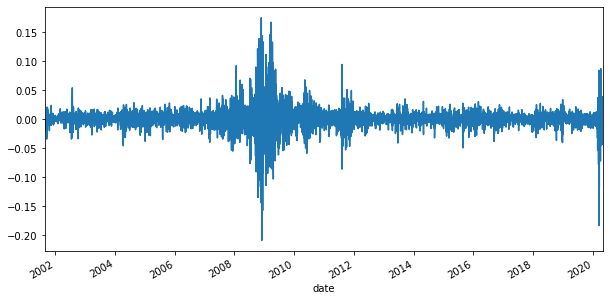

In [23]:
#plot daily returns of RWR

daily_returns_rwr.plot(figsize=(10,5))

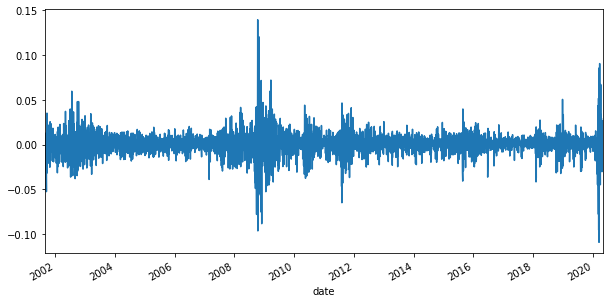

In [24]:
#plot daily returns of SPY

daily_returns_spy.plot(figsize=(10,5))

In [25]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xlb = (1 + concat_df['XLB_return']).cumprod()
cumulative_returns_xlk = (1 + concat_df['XLK_return']).cumprod()
cumulative_returns_rwr = (1 + concat_df['RWR_return']).cumprod()
cumulative_returns_spy = (1 + concat_df['SPY_return']).cumprod()

cumulative_returns_xlb.head()

date
2001-08-28    0.990576
2001-08-29    0.978016
2001-08-30    0.974426
2001-08-31    0.982951
2001-09-04    0.982951
Name: XLB_return, dtype: float64

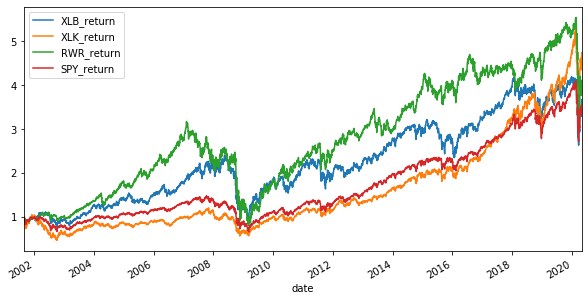

In [26]:
#plot cumulative returns

cumulative_returns_xlb.plot(figsize=(10,5),legend = True)
cumulative_returns_xlk.plot(figsize=(10,5),legend = True)
cumulative_returns_rwr.plot(figsize=(10,5),legend=True)
cumulative_returns_spy.plot(figsize=(10,5),legend=True)


In [27]:
# Calculate Standard Deviations for each sector
xlb_std = concat_df['XLB_return'].std()
print(f' XLB standard deviation is {xlb_std}')


xlk_std = concat_df['XLK_return'].std()
print(f' XLK standard deviation is {xlk_std}')

rwr_std = concat_df['RWR_return'].std()
print(f' RWR standard deviation is {rwr_std}')

spy_std = concat_df['SPY_return'].std()
print(f' SPY standard deviation is {spy_std}')


# Identify the sector with highest standard deviation (riskiest)
sectors = [xlb_std, xlk_std, rwr_std, spy_std]
sectors.sort()
print(sectors)

 XLB standard deviation is 0.01514207467913535
 XLK standard deviation is 0.014744996477617059
 RWR standard deviation is 0.018883861310395145
 SPY standard deviation is 0.012345010226744725
[0.012345010226744725, 0.014744996477617059, 0.01514207467913535, 0.018883861310395145]


In [28]:
# Calculate the annualized standard deviation (252 trading days) for each sector
annualized_xlb_std = xlb_std * np.sqrt(252)
annualized_xlb_std

annualized_xlk_std = xlk_std * np.sqrt(252)
annualized_xlk_std

annualized_rwr_std = rwr_std * np.sqrt(252)
annualized_rwr_std

annualized_spy_std = spy_std * np.sqrt(252)
annualized_spy_std


0.19597096195509384

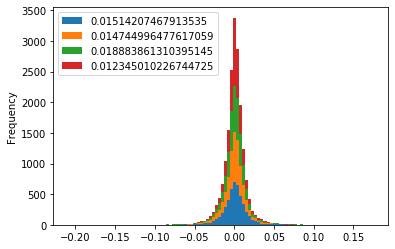

In [29]:
#Plot

sectors_std = pd.DataFrame({
    xlb_std: concat_df['XLB_return'],
    xlk_std: concat_df['XLK_return'],
    rwr_std: concat_df['RWR_return'],
    spy_std: concat_df['SPY_return']
})

sectors_std.plot.hist(stacked=True, bins=100)

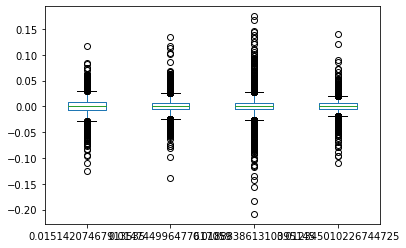

In [30]:
# Plot box plot
sectors_std.plot.box()

In [31]:
# Calculate Sharpe Ratios for the sectors

XLB_sharpe_ratio = (concat_df['XLB_return'].mean() * 252) / (concat_df['XLB_return'].std() * np.sqrt(252))

XLK_sharpe_ratio = (concat_df['XLK_return'].mean() * 252) / (concat_df['XLK_return'].std() * np.sqrt(252))

RWR_sharpe_ratio = (concat_df['RWR_return'].mean() * 252) / (concat_df['RWR_return'].std() * np.sqrt(252))

SPY_sharpe_ratio = (concat_df['SPY_return'].mean() * 252) / (concat_df['SPY_return'].std() * np.sqrt(252))

print(f" XLB: {XLB_sharpe_ratio}, XLK: {XLK_sharpe_ratio}, RWR:{RWR_sharpe_ratio}, SPY: {SPY_sharpe_ratio}")





 XLB: 0.404182568722531, XLK: 0.4728811127064851, RWR:0.40057778470737876, SPY: 0.4439287288219412


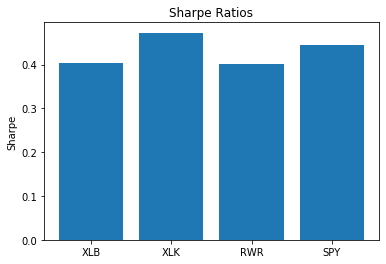

In [32]:
#Plot the sharpe ratios

objects = ('XLB', 'XLK', 'RWR', 'SPY')
y_pos = np.arange(len(objects))
sharpe = [XLB_sharpe_ratio,XLK_sharpe_ratio,RWR_sharpe_ratio, SPY_sharpe_ratio]

plt.bar(y_pos, sharpe, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Sharpe')
plt.title('Sharpe Ratios')

plt.show()

In [33]:
# Concat returns into one DataFrame
returns_only_df = pd.concat([daily_returns_xlb, daily_returns_xlk, daily_returns_rwr , daily_returns_spy], axis='columns', join='inner')
returns_only_df.head()

#Fix column names
columns = ['XLB_return', 'XLK_return', 'RWR_return', 'SPY_return']
returns_only_df.columns = columns
returns_only_df.head()

# Drop nulls
returns_only_df.dropna(inplace=True)

#count nulls 
returns_only_df.isnull().sum()






XLB_return    0
XLK_return    0
RWR_return    0
SPY_return    0
dtype: int64

In [34]:
#Check correlation

correlation = returns_only_df.corr()
correlation

,XLB_return,XLK_return,RWR_return,SPY_return
XLB_return,1.000000,0.729106,0.623073,0.844442
XLK_return,0.729106,1.000000,0.559519,0.894536
RWR_return,0.623073,0.559519,1.000000,0.700534
SPY_return,0.844442,0.894536,0.700534,1.000000


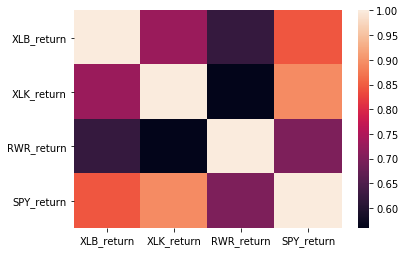

In [35]:
# Create a heatmap from the correlation values
sns.heatmap(correlation)

In [36]:
#BETA CALCULATION XLB and SPY

# Calculate covariance of XLB vs. S&P 500
covariance = returns_only_df['XLB_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of XLB
XLB_beta = covariance / variance
XLB_beta

1.035771248937571

In [37]:
#BETA CALCULATION XLK and SPY

# Calculate covariance of XLK vs. S&P 500
covariance = returns_only_df['XLK_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of XLK
XLK_beta = covariance / variance
XLK_beta

1.0684426195188277

In [38]:
#BETA CALCULATION RWR and SPY

# Calculate covariance of RWR vs. S&P 500
covariance = returns_only_df['RWR_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of RWR
RWR_beta = covariance / variance
RWR_beta

1.0715890309668783

A 10,000 investment in XLB would have grown to 35608.14567218291


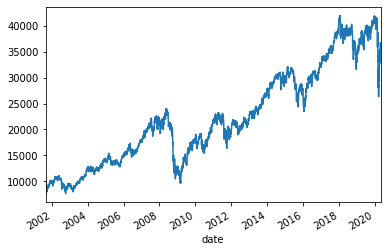

In [39]:
# Plot the returns of XLB in terms of money
initial_investment = 10000
cumulative_profit_xlb = initial_investment * cumulative_returns_xlb
print(f'A 10,000 investment in XLB would have grown to {cumulative_profit_xlb[-1]}')
cumulative_profit_xlb.plot()

A 10,000 investment in XLK would have grown to 47248.12372071861


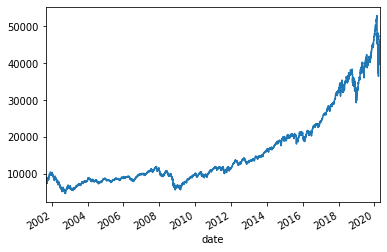

In [40]:
# Plot the returns of XLK in terms of money
initial_investment = 10000
cumulative_profit_xlk = initial_investment * cumulative_returns_xlk
print(f'A 10,000 investment in XLK would have grown to {cumulative_profit_xlk[-1]}')
cumulative_profit_xlk.plot()

A 10,000 investment in RWR would have grown to 40420.24178436653


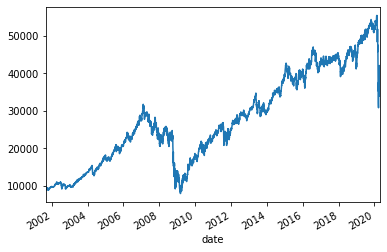

In [41]:
# Plot the returns of RWR in terms of money
initial_investment = 10000
cumulative_profit_rwr = initial_investment * cumulative_returns_rwr
print(f'A 10,000 investment in RWR would have grown to {cumulative_profit_rwr[-1]}')
cumulative_profit_rwr.plot()

A 10,000 investment in SPY would have grown to 35368.27545564896


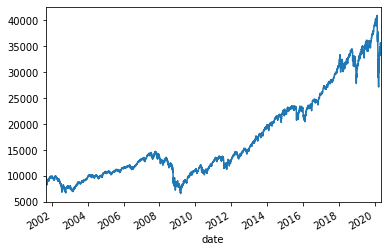

In [42]:
# Plot the returns of SPY in terms of money
initial_investment = 10000
cumulative_profit_spy = initial_investment * cumulative_returns_spy
print(f'A 10,000 investment in SPY would have grown to {cumulative_profit_spy[-1]}')
cumulative_profit_spy.plot()

In [43]:
#START MONTE CARLO ANALYSIS (XLB)

#check concat_df
concat_df.head()


,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
date,,,,,,,,
2001-08-28,14.4324,18.8107,19.2651,80.9499,-0.009424,-0.027710,0.000000,-0.014370
2001-08-29,14.2494,18.4533,18.8996,80.1862,-0.012680,-0.019000,-0.018972,-0.009434
2001-08-30,14.1971,17.7384,18.8082,78.6589,-0.003670,-0.038741,-0.004836,-0.019047
2001-08-31,14.3213,17.8861,18.7625,79.2837,0.008748,0.008327,-0.002430,0.007943
2001-09-04,14.3213,17.4976,18.7321,78.7283,0.000000,-0.021721,-0.001620,-0.007005


In [44]:
# Calculate the mean of daily returns for XLB
avg_daily_return_xlb = concat_df.mean()['XLB_return']
print(f"The average daily return of XLB is {avg_daily_return_xlb}")


# Calculate the mean of daily returns for RWR
avg_daily_return_rwr = concat_df.mean()['RWR_return']
print(f"The average daily return of RWR is {avg_daily_return_rwr}")

# Calculate the mean of daily returns for SPY
avg_daily_return_spy = concat_df.mean()['SPY_return']
print(f"The average daily return of SPY is {avg_daily_return_spy}")

# Standard deviation was calculated previously - xlb_std, xlk_std, rwr_std, spy_std

The average daily return of XLB is 0.0003855340078012791
The average daily return of RWR is 0.0004765158954285654
The average daily return of SPY is 0.00034522674613784846


In [45]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLB from DataFrame

num_trading_days = 30
XLB_last_price = concat_df['XLB close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLB_df = pd.DataFrame()




In [46]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_XLB_prices = [XLB_last_price]
    simulated_XLB_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLB_prices[-1] * (1 + np.random.normal(avg_daily_return_xlb, xlb_std))
        # Append the simulated price to the list
        simulated_XLB_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLB_df[f"Simulation {n+1}"] = pd.Series(simulated_XLB_prices)

simulated_prices_XLB_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,...,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000,51.880000
1,51.827059,53.122247,50.443601,52.846733,52.376129,52.490152,52.285276,51.365640,51.450346,51.886797,...,52.624100,53.601261,51.371829,51.380575,51.789252,53.664153,53.978967,51.773976,52.772095,53.009344
2,51.683565,52.486311,49.898939,54.480249,53.672635,52.614082,51.743205,50.514238,51.469353,50.741471,...,52.976838,53.739457,49.507734,51.846120,52.900224,53.802931,54.563998,51.293541,53.371534,53.283248
3,51.783616,52.460763,49.071071,54.825407,54.219007,53.536922,51.560309,50.019119,53.477033,50.906718,...,53.843033,52.233741,49.445748,51.353986,52.237138,52.992802,53.830993,52.712849,53.013595,53.067472
4,51.744778,51.975115,49.225999,53.576186,54.003942,52.869846,51.277604,50.867164,53.420528,51.655940,...,53.859959,50.984042,49.097067,51.098199,52.647479,53.887562,54.400863,51.385815,52.862222,52.237419


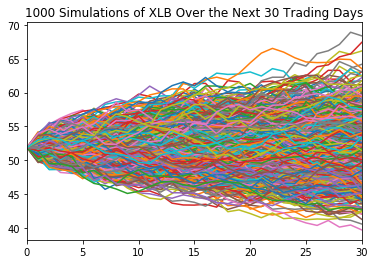

In [47]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLB Over the Next 30 Trading Days"
simulated_prices_XLB_df.plot(legend=None, title=plot_title)

In [48]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_XLB = simulated_prices_XLB_df.iloc[-1, :]
simulated_ending_prices_XLB.head()

Simulation 1    49.359658
Simulation 2    52.535775
Simulation 3    49.370677
Simulation 4    57.732777
Simulation 5    59.365792
Name: 30, dtype: float64

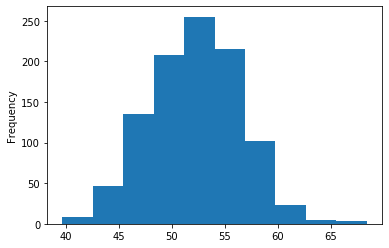

In [49]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLB.plot(kind='hist')

In [50]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLB.quantile(q=[0.025, 0.975])
confidence_interval

0.025    44.294503
0.975    60.419388
Name: 30, dtype: float64

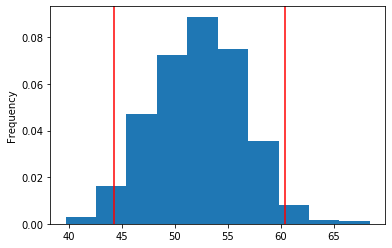

In [51]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLB.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [52]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - XLB_last_price) / XLB_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - XLB_last_price) / XLB_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in XLB"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in XLB over the next 30 trading days will end within in the range of $8537.88 and $11645.99


In [53]:
#START MONTE CARLO ANALYSIS XLK

# Calculate the mean of daily returns for XLK
avg_daily_return_xlk = concat_df.mean()['XLK_return']
print(f"The average daily return of XLK is {avg_daily_return_xlk}")

The average daily return of XLK is 0.0004392344253992596


In [54]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLK from DataFrame

num_trading_days = 30
XLK_last_price = concat_df['XLK close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLK_df = pd.DataFrame()

In [55]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_XLK_prices = [XLK_last_price]
    simulated_XLK_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLK_prices[-1] * (1 + np.random.normal(avg_daily_return_xlk, xlk_std))
        # Append the simulated price to the list
        simulated_XLK_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLK_df[f"Simulation {n+1}"] = pd.Series(simulated_XLK_prices)

simulated_prices_XLK_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,...,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000,91.410000
1,91.954036,91.664427,93.954609,92.231917,91.687923,90.904356,89.087054,90.616428,93.587466,90.403855,...,91.051923,91.567949,88.140847,91.381765,91.476585,90.758268,91.126884,92.051936,91.163524,92.244350
2,90.103785,90.713523,91.809014,92.883880,92.093855,90.778768,87.998695,89.885267,93.672368,91.384491,...,93.222072,91.958138,89.294192,92.183737,91.335689,88.634456,90.477493,92.895418,90.279445,91.764259
3,88.786911,90.216028,91.444585,93.796270,93.376408,92.562140,87.634644,89.446481,92.365591,90.316707,...,93.907226,92.322984,89.492051,91.063078,91.847969,88.640586,88.411084,92.480753,90.864517,94.360363
4,89.547965,90.227830,91.042857,93.586458,91.475177,93.825526,85.457370,90.149475,94.001976,89.829261,...,92.577178,91.588912,87.982418,92.303283,91.310633,89.223102,88.345624,93.501827,91.380257,93.522516


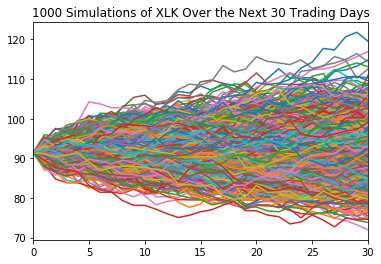

In [56]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLK Over the Next 30 Trading Days"
simulated_prices_XLK_df.plot(legend=None, title=plot_title)

In [57]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_XLK = simulated_prices_XLK_df.iloc[-1, :]
simulated_ending_prices_XLK.head()

Simulation 1    93.567776
Simulation 2    83.376726
Simulation 3    80.709582
Simulation 4    97.418123
Simulation 5    95.377889
Name: 30, dtype: float64

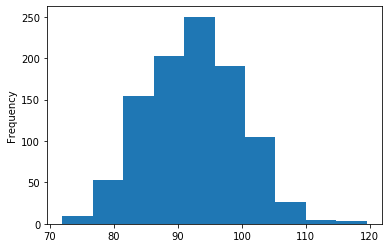

In [58]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLK.plot(kind='hist')

In [59]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLK.quantile(q=[0.025, 0.975])
confidence_interval

0.025     78.978557
0.975    106.087564
Name: 30, dtype: float64

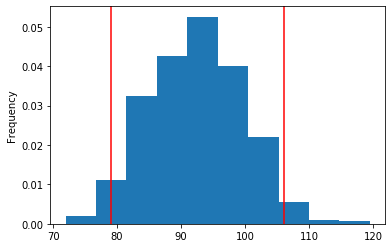

In [60]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLK.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [61]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - XLK_last_price) / XLK_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - XLK_last_price) / XLK_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in XLK"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in XLK over the next 30 trading days will end within in the range of $8640.03 and $11605.68


In [62]:
#START MONTE CARLO ANALYSIS RWR

# Calculate the mean of daily returns for RWR
avg_daily_return_rwr = concat_df.mean()['RWR_return']
print(f"The average daily return of RWR is {avg_daily_return_rwr}")

The average daily return of RWR is 0.0004765158954285654


In [63]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLK from DataFrame

num_trading_days = 30
RWR_last_price = concat_df['RWR close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_RWR_df = pd.DataFrame()

In [64]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_RWR_prices = [RWR_last_price]
    simulated_RWR_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_RWR_prices[-1] * (1 + np.random.normal(avg_daily_return_rwr, rwr_std))
        # Append the simulated price to the list
        simulated_RWR_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_RWR_df[f"Simulation {n+1}"] = pd.Series(simulated_RWR_prices)

simulated_prices_RWR_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,...,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000,77.870000
1,78.006441,76.954079,77.387350,79.724490,78.440881,78.452526,77.630043,78.115394,78.227543,76.660417,...,81.112811,80.722977,79.109158,78.643354,75.974538,76.736863,76.993329,79.909276,78.444157,77.175237
2,80.023333,76.167777,76.690306,78.418109,78.986301,80.091981,76.092843,76.291552,79.713829,76.481096,...,83.781786,80.686896,78.832188,76.276937,78.992098,78.151423,74.466767,79.435006,77.849652,79.492053
3,78.359921,78.680035,75.788687,77.252974,78.815796,78.417632,74.712597,77.720001,81.767811,76.747538,...,82.893940,77.592735,81.583260,77.037020,79.424149,78.468362,73.311541,79.435841,76.121590,81.314644
4,78.711012,79.862861,73.459919,78.432804,78.280846,80.035640,72.668975,79.788454,82.649879,75.877644,...,83.285541,74.982054,82.176331,77.543495,81.129772,80.083490,76.573849,80.799514,75.678460,82.201763


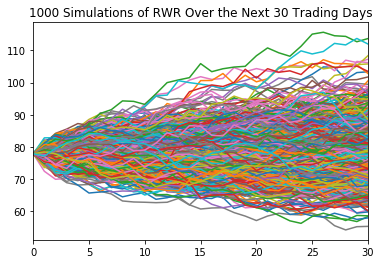

In [65]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of RWR Over the Next 30 Trading Days"
simulated_prices_RWR_df.plot(legend=None, title=plot_title)

In [66]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_RWR = simulated_prices_RWR_df.iloc[-1, :]
simulated_ending_prices_RWR.head()

Simulation 1    81.159597
Simulation 2    80.927613
Simulation 3    79.120046
Simulation 4    86.374385
Simulation 5    93.594315
Name: 30, dtype: float64

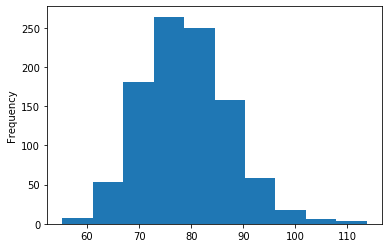

In [67]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_RWR.plot(kind='hist')

In [68]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_RWR.quantile(q=[0.025, 0.975])
confidence_interval

0.025    63.794916
0.975    96.428457
Name: 30, dtype: float64

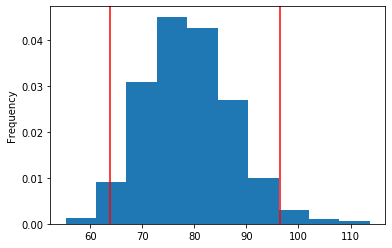

In [69]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_RWR.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [70]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - RWR_last_price) / RWR_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - RWR_last_price) / RWR_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in RWR"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in RWR over the next 504 trading days will end within in the range of $8192.49 and $12383.26


In [71]:
#START MONTE CARLO ANALYSIS SPY

# Calculate the mean of daily returns for SPY
avg_daily_return_spy = concat_df.mean()['SPY_return']
print(f"The average daily return of SPY is {avg_daily_return_spy}")

The average daily return of SPY is 0.00034522674613784846


In [72]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of SPY from DataFrame

num_trading_days = 30
SPY_last_price = concat_df['SPY close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_SPY_df = pd.DataFrame()

In [73]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_SPY_prices = [SPY_last_price]
    simulated_SPY_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, spy_std))
        # Append the simulated price to the list
        simulated_SPY_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_SPY_df[f"Simulation {n+1}"] = pd.Series(simulated_SPY_prices)

simulated_prices_SPY_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,...,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000,290.480000
1,292.735332,292.966693,292.044261,295.392148,284.674828,282.022267,289.044404,296.040776,295.394108,294.918219,...,288.004216,288.012182,291.225347,294.998703,291.819807,291.252761,289.871167,292.010739,284.643404,286.915173
2,295.270440,297.727270,295.206663,294.893066,286.671268,280.237014,285.119753,289.522165,300.369931,295.566883,...,283.981018,287.254656,294.388692,304.613795,292.626331,287.400805,289.815782,297.612819,289.457502,285.402703
3,296.225420,299.941695,296.844124,301.533793,289.598844,278.346748,278.514759,290.842124,296.481193,294.642259,...,286.158559,291.511398,293.759570,302.087322,296.287887,286.493443,290.508497,297.446302,288.557885,283.985434
4,301.657430,305.946126,299.682813,309.032978,290.968548,275.963235,282.561141,294.495374,294.106559,296.461044,...,288.395483,286.834272,298.112836,293.531934,298.159291,289.011119,292.807070,295.787423,281.864299,289.717273


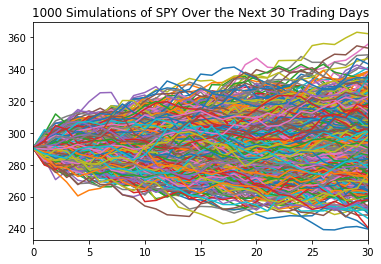

In [74]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of SPY Over the Next 30 Trading Days"
simulated_prices_SPY_df.plot(legend=None, title=plot_title)

In [75]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_SPY = simulated_prices_SPY_df.iloc[-1, :]
simulated_ending_prices_SPY.head()

Simulation 1    286.318188
Simulation 2    310.083902
Simulation 3    306.041555
Simulation 4    278.552858
Simulation 5    308.382588
Name: 30, dtype: float64

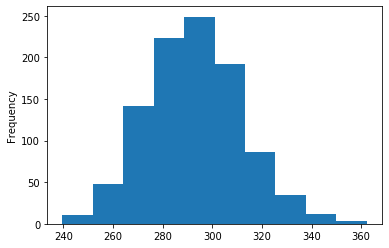

In [76]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_SPY.plot(kind='hist')

In [77]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_SPY.quantile(q=[0.025, 0.975])
confidence_interval

0.025    258.389408
0.975    333.747017
Name: 30, dtype: float64

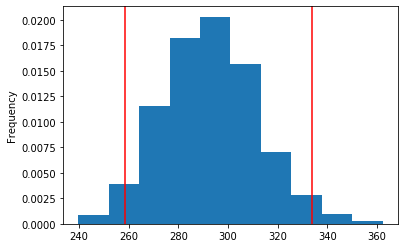

In [78]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_SPY.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [79]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - SPY_last_price) / SPY_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - SPY_last_price) / SPY_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in SPY"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in SPY over the next 30 trading days will end within in the range of $8895.26 and $11489.5
